# **STOCK TRADING USING REINFORCEMENT LEARNING**

---









# STEP 1: IMPORT THE LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
!pip install yfinance --upgrade --no-cache-dir
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

     |████████████████████████████████| 5.5MB 11.9MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=6826f23d1d4cd9eeef2fa67be85dce337a456f8f2ca217bf63c4e10ddb07e226
  Stored in directory: /tmp/pip-ephem-wheel-cache-y88o_bgn/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


# STEP 2: IMPORT THE DATA

In [2]:
yf.pdr_override()
df_full = pdr.get_data_yahoo("INFY.NS", start="2018-01-01").reset_index()
df_full.to_csv("Infosys.csv",index=False)
df_full.head()

[*********************100%***********************]  1 of 1 downloaded


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,518.849976,522.250000,515.000000,516.775024,474.472595,5431340
1,2018-01-02,518.625000,521.000000,511.500000,514.849976,472.705139,6112248
2,2018-01-03,514.250000,515.799988,509.299988,510.649994,468.848938,6846552
3,2018-01-04,510.500000,510.500000,504.799988,507.700012,466.140472,8947614
4,2018-01-05,507.649994,513.200012,503.000000,506.000000,464.579559,11025976


In [3]:
df_full.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
781,2021-03-04,1335.000000,1363.849976,1325.900024,1330.349976,1330.349976,12041941
782,2021-03-05,1328.500000,1340.000000,1305.050049,1316.699951,1316.699951,6486176
783,2021-03-08,1324.800049,1346.099976,1317.199951,1335.750000,1335.750000,5119392
784,2021-03-09,1329.500000,1350.449951,1318.750000,1345.550049,1345.550049,6518173
785,2021-03-12,1373.000000,1391.699951,1370.050049,1374.849976,1374.849976,9459256


# STEP 3: BUILD THE Q-LEARNING AGENT

In [4]:
df= df_full.copy()
name = 'Q-learning agent'
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

# STEP 4: TRAIN THE AGENT

In [5]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: -175.374821.3, cost: 1.160169, total money: 9824.625179
epoch: 20, total rewards: -70.699775.3, cost: 0.413492, total money: 9929.300225
epoch: 30, total rewards: -423.174781.3, cost: 0.214243, total money: 9576.825219
epoch: 40, total rewards: 102.474942.3, cost: 0.175690, total money: 10102.474942
epoch: 50, total rewards: -176.324928.3, cost: 0.081042, total money: 9823.675072
epoch: 60, total rewards: 60.300132.3, cost: 0.077373, total money: 10060.300132
epoch: 70, total rewards: 126.775051.3, cost: 0.054257, total money: 10126.775051
epoch: 80, total rewards: -202.075049.3, cost: 0.028401, total money: 9797.924951
epoch: 90, total rewards: 261.449915.3, cost: 0.028589, total money: 10261.449915
epoch: 100, total rewards: -198.449987.3, cost: 0.017446, total money: 9801.550013
epoch: 110, total rewards: 57.599942.3, cost: 0.170837, total money: 10057.599942
epoch: 120, total rewards: -43.549964.3, cost: 0.010618, total money: 9956.450036
epoch: 130, total

# STEP 5: TEST THE AGENT

In [6]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 514.849976, total balance 9485.150024
day 2: buy 1 unit at price 510.649994, total balance 8974.500030
day 3, sell 1 unit at price 507.700012, investment -1.388747 %, total balance 9482.200042,
day 4, sell 1 unit at price 506.000000, investment -0.910603 %, total balance 9988.200042,
day 10: buy 1 unit at price 540.575012, total balance 9447.625030
day 11, sell 1 unit at price 561.424988, investment 3.857000 %, total balance 10009.050018,
day 14: buy 1 unit at price 571.724976, total balance 9437.325042
day 15: buy 1 unit at price 575.000000, total balance 8862.325042
day 16: buy 1 unit at price 588.549988, total balance 8273.775054
day 18: buy 1 unit at price 587.700012, total balance 7686.075042
day 21, sell 1 unit at price 575.125000, investment 0.594696 %, total balance 8261.200042,
day 22, sell 1 unit at price 572.299988, investment -0.469567 %, total balance 8833.500030,
day 24, sell 1 unit at price 569.099976, investment -3.304734 %, total balance 9402

# STEP 6: PLOT THE CALLS

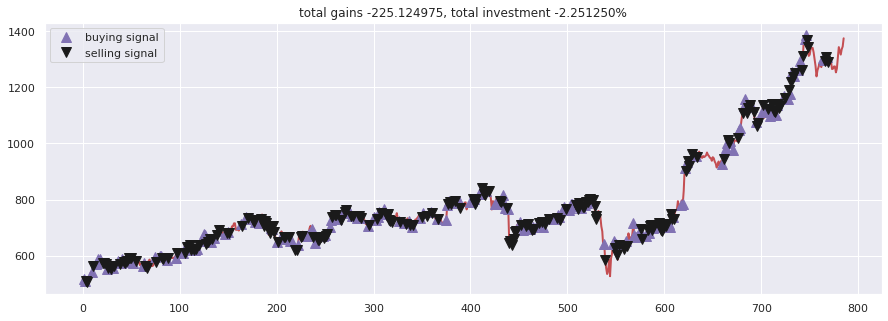

In [7]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()